## IMDB Movie Review Dataset - Sentiment Analysis

Loads and processes the IMDB Large Movie Review Dataset for sentiment analysis. The dataset contains 50,000 movie reviews split evenly into 25k train and 25k test sets with balanced sentiment labels (positive/negative).

### Dataset Structure
- **Training set**: 25,000 reviews (12,500 positive, 12,500 negative)
- **Test set**: 25,000 reviews (12,500 positive, 12,500 negative)
- **Directory structure**: `train/` and `test/` folders, each containing `pos/` and `neg/` subdirectories
- **File format**: Individual text files named `[id]_[rating].txt`

### Data Loading Function
The `load_imdb_data()` function:
- **Input**: Path to data directory (train or test)
- **Output**: Tuple of (reviews, labels) where reviews are text strings and labels are integers (1=positive, 0=negative)

In [15]:
import os
import pandas as pd

def load_imdb_data(data_dir):
    reviews = []
    labels = []
    
    # Load positive reviews
    pos_dir = os.path.join(data_dir, 'pos')
    if os.path.exists(pos_dir):
        for filename in os.listdir(pos_dir):
            if filename.endswith('.txt'):
                with open(os.path.join(pos_dir, filename), 'r', encoding='utf-8') as f:
                    reviews.append(f.read())
                    labels.append(1)  # Positive label
    
    # Load negative reviews
    neg_dir = os.path.join(data_dir, 'neg')
    if os.path.exists(neg_dir):
        for filename in os.listdir(neg_dir):
            if filename.endswith('.txt'):
                with open(os.path.join(neg_dir, filename), 'r', encoding='utf-8') as f:
                    reviews.append(f.read())
                    labels.append(0)  # Negative label
    
    return reviews, labels

### Load IMDB Dataset
Loads the dataset for training and testing.

In [16]:
# Dataset path - adjust this path according to your dataset location
dataset_path = "imdb_dataset"

train_reviews, train_labels = load_imdb_data(os.path.join(dataset_path, 'train'))

test_reviews, test_labels = load_imdb_data(os.path.join(dataset_path, 'test'))

train_df = pd.DataFrame({
    'review': train_reviews,
    'sentiment': train_labels
})

test_df = pd.DataFrame({
    'review': test_reviews,
    'sentiment': test_labels
})

print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nTraining set sentiment distribution:")
print(train_df['sentiment'].value_counts())
print(f"\nTest set sentiment distribution:")
print(test_df['sentiment'].value_counts())


Training set shape: (25000, 2)
Test set shape: (25000, 2)

Training set sentiment distribution:
sentiment
1    12500
0    12500
Name: count, dtype: int64

Test set sentiment distribution:
sentiment
1    12500
0    12500
Name: count, dtype: int64


### Binary Mapping for Multi-Class Sentiment Analysis

Converts 5-class sentiment predictions to binary classification by aggregating scores from related sentiment categories.

In [103]:
def map_5class_to_binary(all_scores):
    negative_sum = 0.0
    positive_sum = 0.0
    
    for item in all_scores:
        label = item['label']
        score = item['score']
        
        if label in ['Very Negative', 'Negative']:
            negative_sum += score
        elif label in ['Very Positive', 'Positive']:
            positive_sum += score
    
    return 1 if positive_sum > negative_sum else 0

### Multilingual Sentiment Analysis

A sentiment analysis classifier using a multilingual model that can handle text in multiple languages.

#### Key Components:
- **Multilingual Model**: Uses `tabularisai/multilingual-sentiment-analysis` for better language support
- **Text Truncation**: Handles long reviews by truncating them to fit model's token limit (512 tokens)
- **Token-based Processing**: Uses the model's tokenizer to ensure proper text handling

In [102]:
from transformers import pipeline, AutoTokenizer

sentiment_pipeline = pipeline("sentiment-analysis", 
                             model="tabularisai/multilingual-sentiment-analysis",
                             top_k=None)

tokenizer = AutoTokenizer.from_pretrained("tabularisai/multilingual-sentiment-analysis")

def truncate_text_by_tokens(text, max_len=512):
    encoded = tokenizer.encode(text, max_length=max_len, truncation=True)
    truncated_text = tokenizer.decode(encoded, skip_special_tokens=True)
    return truncated_text

def analyze_sentiment(test_df, num_samples):
    predicted_df = test_df.sample(n=num_samples, random_state=42).copy()
    predictions = []
    for review in predicted_df["review"].tolist():
        review = truncate_text_by_tokens(review)
        raw_scores = sentiment_pipeline(review)
        binary_score = map_5class_to_binary(raw_scores[0])
        predictions.append(binary_score)
    predicted_df["predicted_sentiment"] = predictions
    return predicted_df

Device set to use mps:0


### Model Performance Evaluation

Evaluation metrics to assess the performance of the sentiment analysis model.

#### Evaluation Metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**

#### Visualization:
- **Confusion Matrix**

In [104]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

def print_metrics(predicted_df):
    accuracy = accuracy_score(predicted_df["sentiment"], predicted_df["predicted_sentiment"])
    precision = precision_score(predicted_df["sentiment"], predicted_df["predicted_sentiment"])
    recall = recall_score(predicted_df["sentiment"], predicted_df["predicted_sentiment"])
    f1 = f1_score(predicted_df["sentiment"], predicted_df["predicted_sentiment"])
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    cm = confusion_matrix(predicted_df['sentiment'], predicted_df['predicted_sentiment'])
    print(f"\nConfusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
    disp.plot(cmap="Blues")

### Run Sentiment Analysis and Evaluate Performance

Execute the sentiment analysis on a sample of 1000 test reviews and display comprehensive performance metrics including accuracy, precision, recall, F1-score, and confusion matrix visualization.

Accuracy: 83.40%
Precision: 82.36%
Recall: 85.91%
F1-Score: 84.10%

Confusion Matrix:


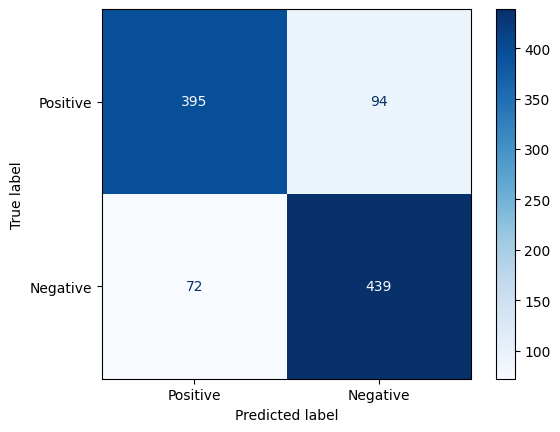

In [105]:
predicted_df = analyze_sentiment(test_df, num_samples=1000)
print_metrics(predicted_df)